### Project 3
This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html

Dataset Link https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

Problem 1: Prediction task is to determine whether a person makes over 50K a year.

Problem 2: Which factors are important

Problem 3: Which algorithms are best for this dataset

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
dfAdultTrain = pd.read_csv('adult.data', header = None)
dfAdultTest = pd.read_csv('adult.test', skiprows = 1, header = None)

In [15]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']
dfAdultTrain.columns = col_labels
dfAdultTest.columns = col_labels

#### 1. Understand the data

In [16]:
dfAdultTest.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


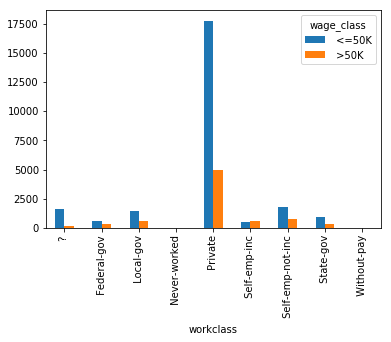

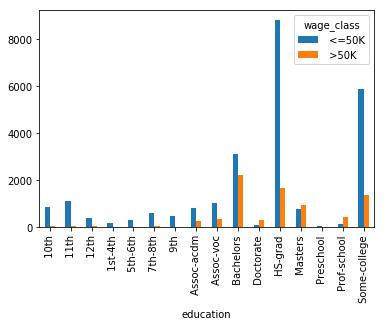

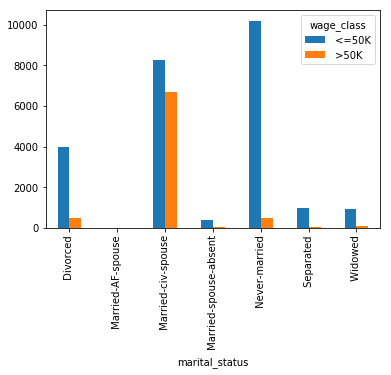

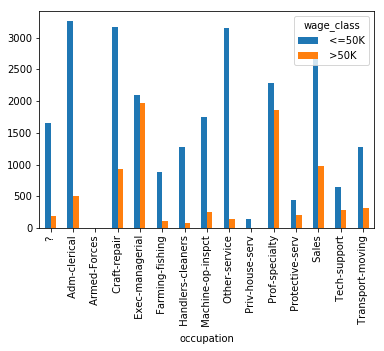

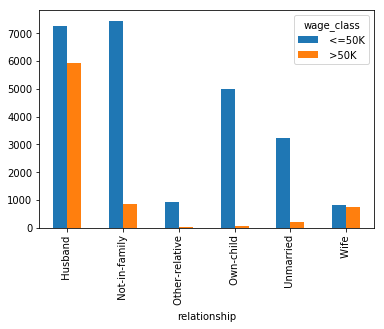

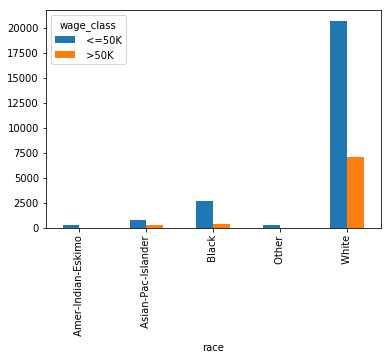

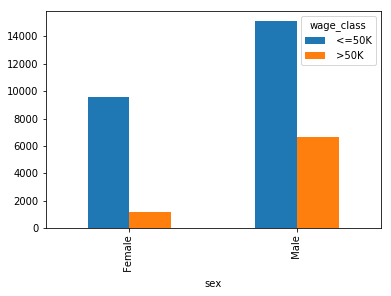

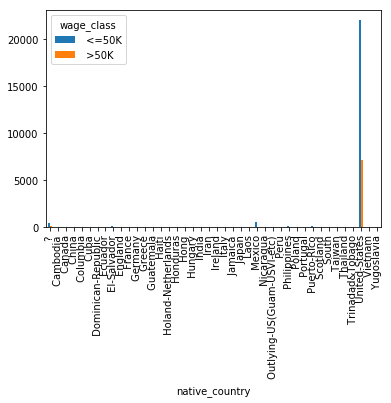

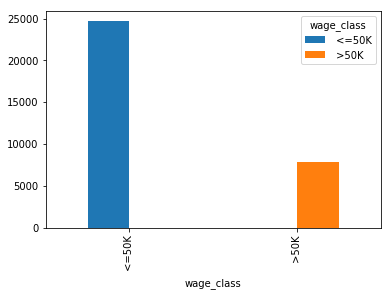

In [17]:
ObjectCol = dfAdultTrain.select_dtypes(include='object').columns.values
train_set_Object = dfAdultTrain[ObjectCol]

for i in train_set_Object:
    pd.crosstab(index=dfAdultTrain[i], columns=dfAdultTrain['wage_class']).plot.bar()


From above visualization, it looks like all columns except education and country, rest all shows some variance so those others are important. We can convert all except education and country into dummies. Education is not important because already another numeric variable of same column exists in the dataset

store values of target into local file system so that can be used any time

In [18]:
temp = dfAdultTrain.wage_class.unique()
print(temp)
np.save('TargetEncoding', temp)

[' <=50K' ' >50K']


In [19]:
# convert both training and testing target variable into same class by replacing "."
dfAdultTest.loc[dfAdultTest['wage_class']==' <=50K.', 'wage_class'] = ' <=50K'
dfAdultTest.loc[dfAdultTest['wage_class']==' >50K.', 'wage_class'] = ' >50K'

## write a function to encode and decode from categorical to numeric

In [20]:
# function to convert categorical column into numerical
def convertToNumeric(dfTemp, colName):
    codes = np.load('TargetEncoding.npy')
    for i in range(codes.size):
        dfTemp.loc[dfTemp[colName] == codes[i], colName] = i
    return dfTemp


In [21]:
dfAdultTrain = convertToNumeric(dfAdultTrain, 'wage_class')
dfAdultTest = convertToNumeric(dfAdultTest, 'wage_class')

In [22]:
def convertToDummies(df):
    ObjectCol = df.select_dtypes(include='object').columns.values
    catColNames = df.select_dtypes(include='object').columns.values.tolist()
    tmpDF = pd.get_dummies(df, columns=catColNames, drop_first=True)
    return tmpDF

def fitXBGModel(params, Xtrain, Ytrain, n_estimators):
    xgbModel = xgb.XGBClassifier(**params, random_state=12345, n_estimators=n_estimators)
    xgbModel.fit(Xtrain, Ytrain)
    
    return xgbModel

def validateModel(xgbModel, Xtest):
    yProb = xgbModel.predict(Xtest)
    yProb[yProb > 0.5] = 1
    yProb[yProb <= 0.5] = 0
    count = 0
    
    for i in range(len(Ytest)):
        if(yProb[i] != Ytest[i]):
            count += 1    
    return count

In [23]:
Ytrain = dfAdultTrain['wage_class']
Xtrain = convertToDummies(dfAdultTrain.drop(columns=['native_country', 'education', 'wage_class']))
Ytest = dfAdultTest['wage_class']
Xtest = convertToDummies(dfAdultTest.drop(columns=['native_country', 'education', 'wage_class']))

In [24]:
names = ["Decision Tree", "Random Forest", "AdaBoost", "Logisic", "GBM"]

In [25]:
classifiers = [
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(n_estimators=200, max_depth=12),
    AdaBoostClassifier(n_estimators=30),
    LogisticRegression(),
    GradientBoostingClassifier(n_estimators=30)]

In [26]:
list(zip(names, classifiers))

[('Decision Tree',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 ('Random Forest',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=12, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)),
 ('AdaBoost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
            learning_rate=1.0, n_estimators=30, random_state=None)),
 ('Logisic',
  Lo

In [27]:
for clf in zip(names, classifiers):
    clf[1].fit(Xtrain, Ytrain) #[imp_cols]
    pred_train_y = clf[1].predict(Xtrain)
    pred_y = clf[1].predict(Xtest)
    print(clf[0], metrics.accuracy_score(pred_train_y, Ytrain), metrics.precision_score(pred_train_y, Ytrain)) #[imp_cols]
    print(clf[0], metrics.accuracy_score(pred_y, Ytest), metrics.precision_score(pred_y, Ytest)) #[imp_cols]

Decision Tree 0.9039648659439207 0.7467159801045785
Decision Tree 0.8462625145875561 0.6198647945917837
Random Forest 0.8754645127606646 0.5953322280321388
Random Forest 0.8640132669983416 0.5621424856994279
AdaBoost 0.8561776358219957 0.5623007269480934
AdaBoost 0.8579325594250967 0.5592823712948518


C:\Users\epadhak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logisic 0.7979177543687234 0.26284912638694047
Logisic 0.7997665991032492 0.25975039001560063
GBM 0.85734467614631 0.5353908940186201
GBM 0.8587924574657576 0.5330213208528342


### Answer 1: here is the answer to problem 1, i.e. to predict the clssification

In [28]:
Ytest.head()
# here output is from the last executed model out of 5 models in a loop
# here output is not decoded but it can also be decoded

0    0
1    0
2    1
3    1
4    0
Name: wage_class, dtype: int64

### Problem 2: Which factors are important

In [29]:
# RandomForestClassifier
featureImportance = pd.DataFrame(Xtrain.columns, classifiers[1].feature_importances_)
featureImportance.sort_index(ascending=False, inplace=True)

In [30]:
print('important features as per RandomForestClassifier')
print('*'*50)
print(featureImportance[featureImportance.index > 0.009])

important features as per RandomForestClassifier
**************************************************
                                           0
0.187122  marital_status_ Married-civ-spouse
0.175132                        capital_gain
0.155270                       education_num
0.074460                                 age
0.068341       marital_status_ Never-married
0.057454                      hours_per_week
0.044866                        capital_loss
0.029891         occupation_ Exec-managerial
0.028332         relationship_ Not-in-family
0.025707          occupation_ Prof-specialty
0.021931                              fnlwgt
0.021692                           sex_ Male
0.016888             relationship_ Own-child
0.012675             relationship_ Unmarried
0.011347                  relationship_ Wife
0.009420           occupation_ Other-service


In [31]:
# RandomForestClassifier
featureImportance = pd.DataFrame(Xtrain.columns, classifiers[4].feature_importances_)
featureImportance.sort_index(ascending=False, inplace=True)

In [32]:
print('important features as per RandomForestClassifier')
print('*'*50)
print(featureImportance[featureImportance.index > 0.009])

important features as per RandomForestClassifier
**************************************************
                                           0
0.417813  marital_status_ Married-civ-spouse
0.212498                       education_num
0.206200                        capital_gain
0.053584                                 age
0.046763                        capital_loss
0.033097                      hours_per_week
0.015885         occupation_ Exec-managerial


#### Answer 2: Above are the important features captured from GradientBoostingClassified and they are also found in RandomForestClassifier

#### Problem 3: Which algorithms are best for this dataset

#### Answer 3: From accuracy and precision, Decision Tree model looks good but REMEMBER, we haven't seach for best hyper tuning parameters for XGBOOST or other models. From below cross validation, it looks model is stable as well

In [33]:

cross_val_score(classifiers[0], Xtrain, Ytrain, cv=5)

array([0.83371718, 0.83952703, 0.83737715, 0.85365479, 0.84597666])